In [1]:
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import torchvision


In [2]:
files=list(Path(r"/Users/damian/Downloads/ds000030_just_brain/").glob("*"))

In [3]:
#images=[nib.load(file).get_fdata() for file in files]

In [4]:
#stack = np.stack(images)

In [5]:
#print(stack.min())
#print(stack.max())
#minimum and maximum values for normalization


In [6]:
def normalize_image(im):
    im = im / 216

In [7]:
data=nib.load(files[0]).get_fdata()

In [8]:
data.shape

(256, 256, 256)

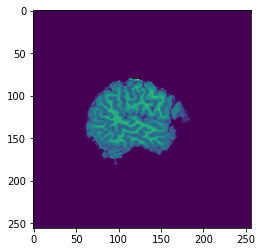

In [9]:
plt.imshow(data[180])

In [10]:
data.min()
data.max()

179.0

In [11]:
import torch
from torchsummary import summary
import numpy as np

In [12]:
from MedicalNet.models.resnet import resnet152

In [13]:
weights_file = r"/Users/damian/Downloads/MedicalNet_pytorch_files2/pretrain/resnet_152.pth"

In [14]:
model = resnet152(sample_input_D=256, sample_input_H=256, sample_input_W=256, num_seg_classes=2)

/Users/damian/BrainHack/MedicalNet/models/resnet.py:173: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')


In [15]:
modstr = lambda k: str(k).replace("module.", "")

In [16]:
module_str_rem = lambda k: str(k).replace("module.", "")
net_dict = model.state_dict() 
pretrain = torch.load(weights_file, map_location=torch.device('cpu'))
pretrain_dict = {modstr(k): v for k, v in pretrain['state_dict'].items()}
net_dict.update(pretrain_dict)
model.load_state_dict(net_dict)

<All keys matched successfully>

In [17]:
newmodel = list(model.children())[:8]
classifier = [torch.nn.AdaptiveMaxPool3d(4), torch.nn.Flatten(), torch.nn.Linear(131072, 4), torch.nn.Sigmoid()] 
newmodel.extend(classifier)

In [18]:
model = torch.nn.Sequential(*newmodel)

In [19]:
#newnewmodel.float()
#summary(newnewmodel,(1,256,256,256))

In [20]:
data.shape

(256, 256, 256)

In [21]:
model.float()
ret = model(torch.tensor([np.expand_dims(data, axis =0)]).float())

/var/folders/xw/1yw1mlg54gd49g34q6hd8sxw0000gn/T/ipykernel_25817/3173324667.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/pytorch/torch/csrc/utils/tensor_new.cpp:210.)
  ret = model(torch.tensor([np.expand_dims(data, axis =0)]).float())


In [22]:
ret.shape

torch.Size([1, 4])

In [27]:
ret.detach().numpy()

array([[0.93357515, 0.40005228, 0.09055284, 0.8733932 ]], dtype=float32)

In [28]:
dataset = ([[data],[[0,1,0,0]]],[[data],[[1,0,0,0]]])

In [29]:
from tqdm import tqdm

def validation(model, dataset, criterion):
    with torch.no_grad():
        loss = 0
        for i, data in tqdm(enumerate(dataset, 0)):
            inputs, labels = data
            labels = torch.tensor(labels).float()
            inputs = torch.tensor(np.expand_dims(inputs, axis =0)).float()
            outputs = model(inputs)
            _loss = criterion(outputs.float(), labels)
            loss += _loss
        return loss 
            
def train_loop(model, train_dataset, val_dataset, epochs, optimizer, criterion):
    train_history = []
    val_history = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in tqdm(enumerate(train_dataset, 0)):
            inputs, labels = data
            labels = torch.tensor(labels).float()
            inputs = torch.tensor(np.expand_dims(inputs, axis =0)).float()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.float(), labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        train_history.append(running_loss)
        print(f'epoch: {epoch + 1} loss: {running_loss}')
        val_loss = validation(model, val_dataset, criterion)
        val_history.append(val_loss)
        print(f"validation loss: {val_loss.numpy()}")
        torch.save(model, Path(f"model_{epoch}.pt"))
        running_loss = 0.0
    print('Finished Training')
    return (train_history, val_history)

In [30]:
import torch.optim as optim

loss = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
model.float()

train_history, val_history = train_loop(model,dataset,dataset,1, optimizer, loss)

2it [03:06, 93.18s/it]


epoch: 1 loss: 0.001


2it [01:09, 34.73s/it]


validation loss: 2.4873366355895996
Finished Training


In [ ]:
validation(model, dataset, loss).numpy()

In [31]:
train_history

[2.4873366355895996]

In [32]:
val_history

[tensor(2.4873)]